# MNIST Wasserstein Generative Adversarial Network
---

This GAN is built using fully connected layers. However, instead of a discriminator using a sigmoid output activation to classify the image, it uses a critic that has ReLU before the output and therefore assigns a higher score to real images. Instead of using BCE Loss, it tries to maximize the Wasserstein distance between the real and fake guess distribution. Likewise, the generator tries to maximize the output of the discriminator (make it think the images are real).

The losses to minimize are as follows:
$$Loss_D = C(G(z)) - C(x)$$
$$Loss_G = -C(G(z))$$
With $C$ being the critic, $G$ being the generator, $z$ is the random noise it samples from, and $x$ is the real image.

In the [paper](https://arxiv.org/pdf/1701.07875.pdf) (Arjovsky et al. 2017), $C$ must be a 1-Lipschitz continuous function. To enforce this, they clip the weights within a certain range. The authors state this is "clearly a terrible way" to do this, but that it is simple. Another option is the gradient penalty introduced in this [paper](https://arxiv.org/pdf/1704.00028.pdf) (Gulrajani et al. 2017), which adds a term
 $$\lambda  (||\nabla C(x)||_2 - 1)^2$$
 to the critic loss to penalize gradients without unit norm. This removes the need for clipping the weights, as they will tend towards unit norm to minimize the loss.


---

## Imports

In [1]:
import torch.optim
from mnist_wgan import Generator, Critic
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

## Get MNIST

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

data = torchvision.datasets.MNIST(
    root="../datasets/",
    train=True,
    download=True,
    transform=transform
)

## Hyperparameters and initialize models

In [8]:
noise_dimension = 100
image_dimension = 28 * 28
features = 256
critic_acceleration = 2
grad_penalty = 10
device = "mps"
fixed_noise = torch.randn((16, noise_dimension)).to(device)
loader = DataLoader(dataset=data, batch_size=512, shuffle=True, num_workers=2)

generator = Generator(noise_dimension, image_dimension, features).to(device)
critic = Critic(image_dimension, features).to(device)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
crit_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-4, betas=(0.5, 0.9))

generator_loss_history = []
critic_loss_history = []

In [9]:
epochs = 100
for epoch in range(epochs):
    for batch, (image, _) in enumerate(loader):
        images = image.view(-1, 784).to(device)
        batch_size = images.shape[0]

        # --- Critic Training --- #
        critic_loss = 0
        for i in range(critic_acceleration):
            noise = torch.randn((batch_size, noise_dimension)).to(device)
            fakes = generator(noise)

            critic_loss = torch.mean(critic(fakes)) - torch.mean(critic(images)) + grad_penalty * critic.gradient_penalty(images, fakes, device)
            critic.zero_grad()
            critic_loss.backward()
            crit_optimizer.step()

        # --- Generator Training --- #
        noise = torch.randn((batch_size, noise_dimension)).to(device)
        fakes = generator(noise)
        generator_loss = -torch.mean(critic(fakes))
        generator.zero_grad()
        generator_loss.backward()
        gen_optimizer.step()
        if batch % 10 == 0:
            generator_loss_history.append(generator_loss.detach().cpu())
            critic_loss_history.append(critic_loss.detach().cpu())
    print(
        f"Epoch {epoch + 1} | Generator Loss: {generator_loss} | Critic Loss: {critic_loss}"
    )



Epoch 1 | Generator Loss: -1.3195877075195312 | Critic Loss: -8.877026557922363
Epoch 2 | Generator Loss: -2.7075629234313965 | Critic Loss: -9.803411483764648
Epoch 3 | Generator Loss: -3.2660694122314453 | Critic Loss: -7.920656681060791
Epoch 4 | Generator Loss: -6.044595241546631 | Critic Loss: -5.685725212097168
Epoch 5 | Generator Loss: -4.362519264221191 | Critic Loss: -5.436763763427734
Epoch 6 | Generator Loss: -3.437837600708008 | Critic Loss: -5.795060634613037
Epoch 7 | Generator Loss: -2.427826404571533 | Critic Loss: -6.175788879394531
Epoch 8 | Generator Loss: -1.3090075254440308 | Critic Loss: -6.600667476654053
Epoch 9 | Generator Loss: -1.7521989345550537 | Critic Loss: -7.495459079742432
Epoch 10 | Generator Loss: -1.4008913040161133 | Critic Loss: -7.260281562805176
Epoch 11 | Generator Loss: -2.4329681396484375 | Critic Loss: -7.7057952880859375
Epoch 12 | Generator Loss: -1.598600149154663 | Critic Loss: -7.4567108154296875
Epoch 13 | Generator Loss: -2.5049972534

## Display Loss Curves

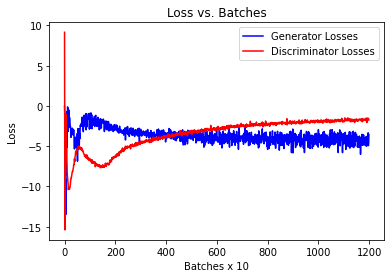

In [10]:
x_axis = range(len(generator_loss_history))
plt.plot(x_axis, generator_loss_history, color="blue", label="Generator Losses")
plt.plot(x_axis, critic_loss_history, color="red", label="Discriminator Losses")
plt.title("Loss vs. Batches")
plt.xlabel("Batches x 10")
plt.ylabel("Loss")
plt.legend(loc="upper right")

## Generate Images

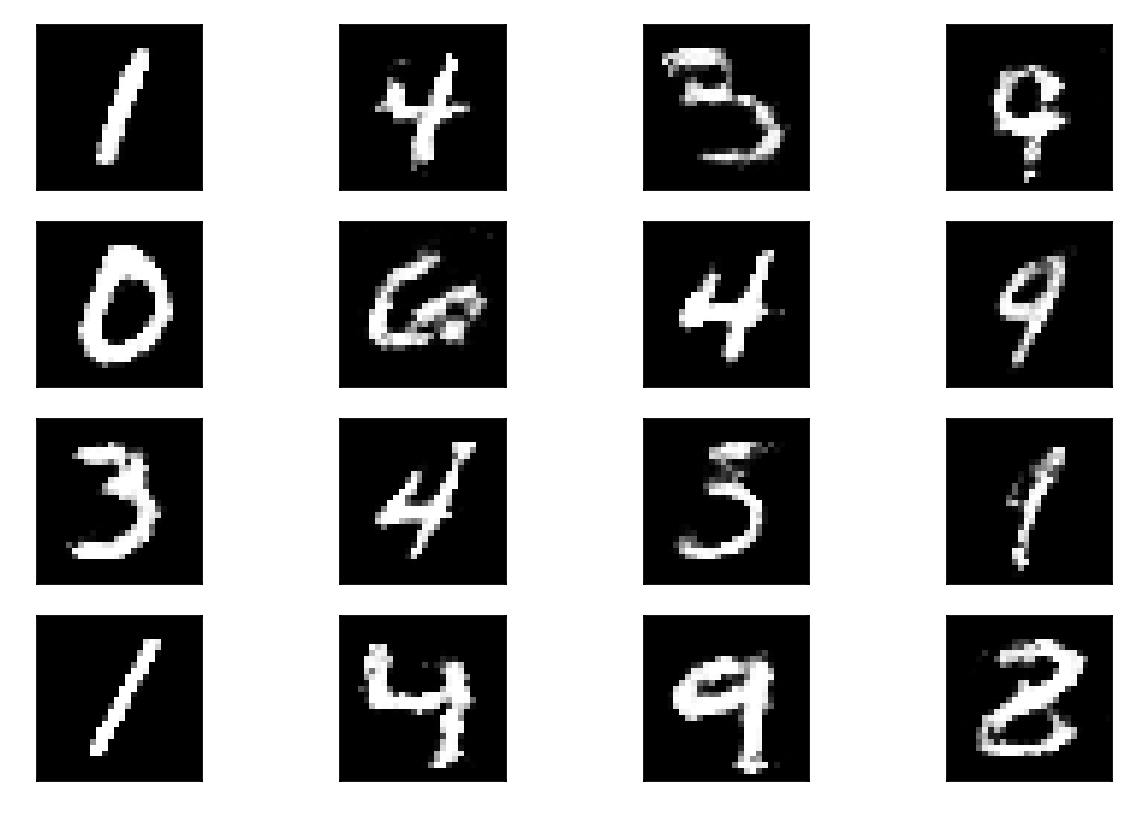

In [12]:
images = []
for i in range(16):
    noise = torch.randn(1, noise_dimension).to(device)
    image = generator(noise).squeeze().detach().cpu().reshape(28, 28).numpy()
    images.append(image)
fig, axes = plt.subplots(4, 4)
fig.set_dpi(250)
for i, ax in enumerate(axes.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(images[i], cmap="gray")